#EQUIPE: Beatriz Emily Silva Aguiar
> matrícula: 22154303

> Turma: CB02

## 1. Neuro-Symbolic AI (NeSy) e Logic Tensor Networks (LTN)

### Neuro-Symbolic Artificial Intelligence (NeSy)

A Inteligência Artificial Neuro-Simbólica (NeSy) combina dois paradigmas tradicionais da Inteligência Artificial:  
(i) **modelos neurais**, responsáveis por aprender padrões a partir de dados contínuos e possivelmente ruidosos, e  
(ii) **representações simbólicas**, responsáveis por expressar conhecimento explícito por meio de regras e axiomas lógicos.

No contexto deste trabalho, essa integração pode ser observada na forma como predicados neurais são utilizados para identificar atributos e relações espaciais entre objetos a partir de suas *features*. Por exemplo, predicados parametrizados por redes neurais foram capazes de inferir o posicionamento relativo entre dois objetos (como esquerda/direita ou acima/abaixo) a partir das coordenadas espaciais.

Além disso, o modelo inclui **parâmetros treináveis guiados por restrições lógicas**, em vez de rótulos diretos.

**Um exemplo disso** é o uso de axiomas envolvendo proximidade espacial. A partir da regra lógica *“se dois objetos são triângulos e possuem o mesmo tamanho, então eles são considerados próximos”*, o parâmetro que define a noção de distância foi ajustado durante o treinamento para satisfazer essa restrição.

Esse tipo de formulação evidencia o poder dos axiomas no paradigma neuro-simbólico, pois eles não apenas impõem consistência ao modelo, mas também orientam o aprendizado de parâmetros contínuos de forma indireta, permitindo que o sistema aprenda conceitos sem supervisão explícita.



---

### Logic Tensor Networks (LTN)

Logic Tensor Networks (LTN) são um framework neuro-simbólico que integra **Lógica de Primeira Ordem (First-Order Logic)** com **redes neurais diferenciáveis**. Em LTN, predicados lógicos são parametrizados por modelos neurais (por exemplo, MLPs), que produzem valores de verdade contínuos no intervalo \([0,1]\).

As fórmulas lógicas são convertidas em funções diferenciáveis por meio de **fuzzy logic**, permitindo que a satisfação das regras seja otimizada via **gradiente descendente**. Dessa forma, o treinamento busca maximizar a **satisfatibilidade global (SAT)** de um conjunto de axiomas, ao mesmo tempo em que ajusta os parâmetros neurais dos predicados.

No contexto deste trabalho, o LTN é utilizado para modelar atributos absolutos (como forma, cor e tamanho) e relações espaciais (como esquerda/direita, acima/abaixo e proximidade), garantindo que o aprendizado respeite restrições lógicas como exclusividade, transitividade, inversos e regras de empilhamento.

Essa abordagem permite um raciocínio mais estruturado e interpretável, indo além de classificações isoladas e incorporando conhecimento simbólico ao processo de aprendizagem.


In [1]:
!pip install LTNtorch


In [2]:
import torch
import torch.nn as nn
import ltn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/Nibi2003/Trabalho-3-IA.git

Cloning into 'Trabalho-3-IA'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 178.23 KiB | 10.48 MiB/s, done.


#Gerar nosso Ground Truth

> Vamos usar um conceito de bounding box

> As formas geométricas ficam demilitadas por um retângulo, dessa forma, conseguiremos destinguir entre small, big e a coordenada (x,y)

> Dessa forma, a coordenada (x,y) vai representar o vértice superior esquerdo do bounding box

> Assim, (40, 80) é um bounding box que está a 80 do topo e 40 da lateral esquerda


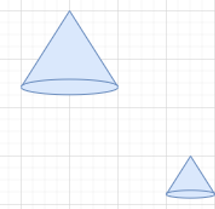

## Estrutura do vetor
 ESTRUTURA DO VETOR [11 features]:

>

    -------------------------------------------------
    [0, 1]    : Posição x, y (0.0 a 1.0)
    [2, 3, 4] : Cores One-Hot (Vermelho, Verde, Azul)
    [5, 6, 7, 8, 9] : Formas One-Hot (Círculo, Quadrado, Cilindro, Cone, Triângulo)
    [10]      : Tamanho (0.0 = Pequeno, 1.0 = Grande)
    -------------------------------------------------



In [4]:
dataset = []


# Helper para adicionar objeto
def add_obj(x, y, color, shape, is_big):
    r, g, b = color
    is_circle   = 1 if shape == "circle" else 0
    is_square   = 1 if shape == "square" else 0
    is_cilindro = 1 if shape == "cylinder" else 0
    is_cone     = 1 if shape == "cone" else 0
    is_triangle = 1 if shape == "triangle" else 0

    dataset.append([
        x, y,
        r, g, b,
        is_circle, is_square, is_cilindro, is_cone, is_triangle,
        is_big
    ])


# QUADRADOS

add_obj(0, 40,   [1,1,0], "square", 0) ## amarelo em rgb = 1, 1, 0
add_obj(360,440, [1,1,0], "square", 1)
add_obj(560,40,  [1,0,0], "square", 0)
add_obj(200,0,   [1,0,0], "square", 1)
add_obj(440,40,  [0,0,1], "square", 0)
add_obj(0,520,   [0,0,1], "square", 1)
add_obj(480,120, [0,1,0], "square", 0)
add_obj(240,520, [0,1,0], "square", 1)

# TRIÂNGULOS
add_obj(600,440, [1,1,0], "triangle", 0)
add_obj(80,720,  [1,1,0], "triangle", 1)
add_obj(480,560, [1,0,0], "triangle", 0)
add_obj(360,640, [1,0,0], "triangle", 1)
add_obj(640,360, [0,0,1], "triangle", 0)
add_obj(0,640,   [0,0,1], "triangle", 1)
add_obj(680,480, [0,1,0], "triangle", 0)
add_obj(160,640, [0,1,0], "triangle", 1)

# CONES
add_obj(160,200, [1,1,0], "cone", 0)
add_obj(0,160,   [1,1,0], "cone", 1)
add_obj(120,40,  [1,0,0], "cone", 0)
add_obj(340,320, [1,0,0], "cone", 1)
add_obj(360,240, [0,0,1], "cone", 0)
add_obj(240,120, [0,0,1], "cone", 1)
add_obj(200,320, [0,1,0], "cone", 0)
add_obj(120,400, [0,1,0], "cone", 1)

# CÍRCULOS
add_obj(680,600, [1,1,0], "circle", 0)
add_obj(800,180, [1,1,0], "circle", 1)
add_obj(800,40,  [1,0,0], "circle", 0)
add_obj(740,360, [1,0,0], "circle", 1)
add_obj(400,760, [0,0,1], "circle", 0)
add_obj(540,640, [0,0,1], "circle", 1)
add_obj(600,560, [0,1,0], "circle", 0)
add_obj(680,40,  [0,1,0], "circle", 1)

# CILINDROS

add_obj(600,760, [1,1,0], "cylinder", 0)
add_obj(100,840, [1,1,0], "cylinder", 1)
add_obj(760,600, [1,0,0], "cylinder", 0)
add_obj(920,40,  [1,0,0], "cylinder", 1)
add_obj(840,320, [0,0,1], "cylinder", 0)
add_obj(920,400, [0,0,1], "cylinder", 1)
add_obj(800,480, [0,1,0], "cylinder", 0)
add_obj(720,680, [0,1,0], "cylinder", 1)

print(f"Total de objetos no dataset: {len(dataset)}")



Total de objetos no dataset: 40


In [5]:
dataset[0] # Aqui temos um quadrado amarelo pequeno em 0,40

[0, 40, 1, 1, 0, 0, 1, 0, 0, 0, 0]

# Espaço para funções auxiliares


In [6]:
def describe_object(vec):
    """
    Recebe um vetor [11] no formato:
    [x, y, r, g, b, is_circle, is_square, is_cilindro, is_cone, is_triangle, is_big]
    e imprime uma descrição legível.
    """

    x, y = vec[0], vec[1]
    r, g, b = vec[2], vec[3], vec[4]
    shape_flags = vec[5:10]
    is_big = vec[10]

    #  Cor
    if r == 1 and g == 1 and b == 0:
        color = "amarelo"
    elif r == 1 and g == 0 and b == 0:
        color = "vermelho"
    elif r == 0 and g == 0 and b == 1:
        color = "azul"
    elif r == 0 and g == 1 and b == 0:
        color = "verde"
    else:
        color = "cor desconhecida"

    #  Forma
    shapes = ["círculo", "quadrado", "cilindro", "cone", "triângulo"]
    try:
        shape = shapes[shape_flags.index(1)]
    except ValueError:
        shape = "forma desconhecida"

    #  Tamanho
    size = "grande" if is_big == 1 else "pequeno"

    print(f"Aqui temos um {shape} {color} {size} em ({int(x)}, {int(y)})")


In [7]:
describe_object(dataset[0])

Aqui temos um quadrado amarelo pequeno em (0, 40)


>> Função auxiliar



In [8]:
from functools import reduce
import operator

def multi_and(*args):
    return reduce(And, args)

def multi_or(*args):
    return reduce(Or, args)


# Setar configurações LTN

In [9]:
# Configure LTNtorch to use the appropriate device
ltn.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {ltn.device}")

Using device: cpu


In [10]:
import torch
import torch.nn as nn
import ltn
from itertools import combinations

FEATURE_SIZE = 11

# 1) CONNECTIVES / QUANTIFIERS
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
sat_agg = ltn.fuzzy_ops.SatAgg()

# Helpers para OR com N termos
def multi_and(*args):
    out = args[0]
    for a in args[1:]:
        out = And(out, a)
    return out

def multi_or(*args):
    out = args[0]
    for a in args[1:]:
        out = Or(out, a)
    return out

# 2) DATA / VARIABLES
dataset_tensor = torch.tensor(dataset, dtype=torch.float32)  # (N,11)
def normalize_positions(dataset_tensor, max_x=1000, max_y=920):
    """
    Normaliza as coordenadas x, y para o intervalo [0, 1], baseado no tamanho máximo
    fornecido (1000 para largura, 920 para altura).
    """
    dataset_tensor[:, 0] /= max_x  # Normaliza o eixo X
    dataset_tensor[:, 1] /= max_y  # Normaliza o eixo Y
    return dataset_tensor

dataset_tensor = normalize_positions(dataset_tensor)

objects = ltn.Variable("objects", dataset_tensor)

---

## Vamos dividir o problema em partes

Nesta atividade, dentre todos os predicados envolvendo forma geométrica, cores, relação espacial, ficou mais conivente separar o problema em partes e comparar um modelo determinístico (ground truth) com um modelo de rede neural MLP. Vamos começar com análise das formas geométricas

---


## PARTE 1: Formas geométricas

---
###  Predicados Formas geométricas

#### (a) Versão determinística

Na abordagem determinística, os predicados lógicos são definidos diretamente a partir das colunas do vetor de atributos do objeto, funcionando como funções exatas que retornam valores em \(\{0,1\}\):

- **Formas:**  
  `isCylinder(x)`, `isCone(x)`, `isTriangle(x)`, `isCircle(x)`, `isSquare(x)`
- **Tamanho:**  
  `isSmall(x)`, `isBig(x)`

#### (b) Versão com MLP

Na abordagem neuro-simbólica, os mesmos predicados são modelados como **predicados neurais**, implementados por **MLPs binárias**, que retornam graus de verdade no intervalo \([0,1]\).  
Esses predicados são treinados por maximização da satisfazibilidade dos axiomas lógicos.

---

### Axiomas (Fórmulas) Formas geometricas

As seguintes fórmulas foram adicionadas à Base de Conhecimento (KB) em ambas as abordagens:

#### (a) Unicidade da forma  
Um objeto não pode possuir mais de uma forma simultaneamente:

$$
\forall x,\; \neg \big( isCircle(x) \land isSquare(x) \land \dots \big)
$$

#### (b) Cobertura (Completude)  
Todo objeto deve possuir necessariamente ao menos uma forma:

$$
\forall x,\; \big( isCircle(x) \lor isSquare(x) \lor \dots \big)
$$

---

### Diferença entre as abordagens

- No modelo determinístico, os axiomas são satisfeitos de maneira exata, resultando em satisfazibilidade unitária.
- No modelo com MLP, os predicados são funções contínuas e diferenciáveis, permitindo aprendizado por gradiente.  
  Nesse caso, pequenas violações locais são toleradas, desde que a satisfazibilidade global da base de conhecimento seja maximizada.

---


### Formas geométricas: Predicados Determinísticos

In [11]:

# 2) DATA / VARIABLES GEOMETRICAS
circulos_tensor    = dataset_tensor[dataset_tensor[:, 5] == 1]
quadrados_tensor   = dataset_tensor[dataset_tensor[:, 6] == 1]
cilindros_tensor   = dataset_tensor[dataset_tensor[:, 7] == 1]
cones_tensor       = dataset_tensor[dataset_tensor[:, 8] == 1]
triangulos_tensor  = dataset_tensor[dataset_tensor[:, 9] == 1]

circulos     = ltn.Variable("circulo", circulos_tensor)
quadrados    = ltn.Variable("quadrado", quadrados_tensor)
cilindros    = ltn.Variable("cilindro", cilindros_tensor)
cones        = ltn.Variable("cone", cones_tensor)
triangulos   = ltn.Variable("triangulo", triangulos_tensor)

# Constantes (um exemplo de cada)
const_circulo   = ltn.Constant(circulos_tensor[0], trainable=False)
const_quadrado  = ltn.Constant(quadrados_tensor[0], trainable=False)
const_cilindro  = ltn.Constant(cilindros_tensor[0], trainable=False)
const_cone      = ltn.Constant(cones_tensor[0], trainable=False)
const_triangulo = ltn.Constant(triangulos_tensor[0], trainable=False)


# subset de Tamanhos diferentes
big_tensor   = dataset_tensor[dataset_tensor[:, 10] == 1]
small_tensor = dataset_tensor[dataset_tensor[:, 10] == 0]
big   = ltn.Variable("big", big_tensor)
small = ltn.Variable("small", small_tensor)

# 3) PREDICATES (leem colunas do vetor) # Predicado determinístico
class ColumnPredicate(nn.Module):
    def __init__(self, col_idx):
        super().__init__()
        self.col_idx = col_idx

    def forward(self, x):
        if hasattr(x, "value"):
            x = x.value
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return x[:, self.col_idx].float()  # (B,)

# Formas (one-hot em [5..9])
isCircle   = ltn.Predicate(ColumnPredicate(5))
isSquare   = ltn.Predicate(ColumnPredicate(6))
isCylinder = ltn.Predicate(ColumnPredicate(7))
isCone     = ltn.Predicate(ColumnPredicate(8))
isTriangle = ltn.Predicate(ColumnPredicate(9))

# Tamanho (coluna 10: small=0, big=1)
isBig = ltn.Predicate(ColumnPredicate(10))

class SmallFromBig(nn.Module):
    def forward(self, x):
        if hasattr(x, "value"):
            x = x.value
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return (1.0 - x[:, 10]).float()

isSmall = ltn.Predicate(SmallFromBig())

# 4) AXIOMS : unicidade + cobertura
def axioms_taxonomy():
    formas = [isCircle, isSquare, isTriangle, isCone, isCylinder]

    # Unicidade de forma: não pode ter duas formas ao mesmo tempo (par-a-par)
    unique_shape = [
        Forall(objects, Not(And(f1(objects), f2(objects))))
        for f1, f2 in combinations(formas, 2)
    ]

    # Cobertura de forma: todo objeto tem pelo menos uma forma
    cover_shape = Forall(objects, multi_or(
        isCircle(objects),
        isSquare(objects),
        isTriangle(objects),
        isCone(objects),
        isCylinder(objects)
    ))

    # Unicidade de tamanho: não pode ser small e big ao mesmo tempo
    unique_size = Forall(objects, Not(And(isSmall(objects), isBig(objects))))

    # Cobertura de tamanho: todo objeto é small ou big
    cover_size = Forall(objects, Or(isSmall(objects), isBig(objects)))

    return sat_agg(*(unique_shape + [cover_shape, unique_size, cover_size]))


def run_queries(tag, dataset_tensor, isCircle, isSquare, isCylinder, isCone, isTriangle):
    print(f"\n== CONSULTAS SOBRE A CENA ({tag}) ==")

    new_objects = dataset_tensor[20:23]
    obj1 = ltn.Constant(new_objects[0], trainable=False)
    obj2 = ltn.Constant(new_objects[1], trainable=False)
    obj3 = ltn.Constant(new_objects[2], trainable=False)

    print(f"OBJ1 é círculo?   {isCircle(obj1).value.item():.4f} | cone? {isCone(obj1).value.item():.4f}")
    print(f"OBJ2 é quadrado?  {isSquare(obj2).value.item():.4f} | cone? {isCone(obj2).value.item():.4f}")
    print(f"OBJ3 é triângulo? {isTriangle(obj3).value.item():.4f} | cone? {isCone(obj3).value.item():.4f}")

    # Debug: imprime o GT one-hot do shape
    def show_gt(o):
        shapes = ["circle","square","cyl","cone","tri"]
        gt = o[5:10].tolist()
        print("GT shape one-hot:", gt, "->", shapes[int(torch.tensor(gt).argmax())])

    print("\n== GROUND TRUTH (SHAPE) ==")
    print("OBJ1:"); show_gt(new_objects[0])
    print("OBJ2:"); show_gt(new_objects[1])
    print("OBJ3:"); show_gt(new_objects[2])


print("=== LTN: KB CHECK (ANTES DO TREINO) ===")
kb_sat_before = axioms_taxonomy()
print(f"Satisfação da KB (taxonomia): {kb_sat_before.item():.4f}")

run_queries("Modelo determinístico", dataset_tensor, isCircle, isSquare, isCylinder, isCone, isTriangle)


=== LTN: KB CHECK (ANTES DO TREINO) ===
Satisfação da KB (taxonomia): 0.9997

== CONSULTAS SOBRE A CENA (Modelo determinístico) ==
OBJ1 é círculo?   0.0000 | cone? 1.0000
OBJ2 é quadrado?  0.0000 | cone? 1.0000
OBJ3 é triângulo? 0.0000 | cone? 1.0000

== GROUND TRUTH (SHAPE) ==
OBJ1:
GT shape one-hot: [0.0, 0.0, 0.0, 1.0, 0.0] -> cone
OBJ2:
GT shape one-hot: [0.0, 0.0, 0.0, 1.0, 0.0] -> cone
OBJ3:
GT shape one-hot: [0.0, 0.0, 0.0, 1.0, 0.0] -> cone


### Formas geometricas: Predicado treinável (MLP)

In [12]:
class MLPPredicate(nn.Module):
    def __init__(self, in_dim=11, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        if hasattr(x, "value"): x = x.value
        if x.dim() == 1: x = x.unsqueeze(0)

        out = self.net(x)
        # O LTN precisa que o output tenha [Batch, 1] para 25 objetos
        return out.view(-1, 1)

isCircle   = ltn.Predicate(MLPPredicate(11))
isSquare   = ltn.Predicate(MLPPredicate(11))
isCylinder = ltn.Predicate(MLPPredicate(11))
isCone     = ltn.Predicate(MLPPredicate(11))
isTriangle = ltn.Predicate(MLPPredicate(11))

isBig   = ltn.Predicate(MLPPredicate(11))
isSmall = ltn.Predicate(MLPPredicate(11))


## COMO SOMENTE RESTRIÇÕES NÃO GARANTEM TREINAMENTO, PRECISAMOS INSERIR FACTOS

def axioms_taxonomy_MLP():
    axioms = []

    # Taxonomia (as regras estruturais)
    formas = [isCircle, isSquare, isTriangle, isCone, isCylinder]
    axioms += [
        Forall(objects, Not(And(f1(objects), f2(objects))))
        for f1, f2 in combinations(formas, 2)
    ]
    axioms.append(Forall(objects, multi_or(
        isCircle(objects), isSquare(objects), isTriangle(objects), isCone(objects), isCylinder(objects)
    )))
    axioms.append(Forall(objects, Not(And(isSmall(objects), isBig(objects)))))
    axioms.append(Forall(objects, Or(isSmall(objects), isBig(objects))))

    # Fatos positivos
    axioms.append(Forall(circulos,    isCircle(circulos)))
    axioms.append(Forall(quadrados,   isSquare(quadrados)))
    axioms.append(Forall(cilindros,   isCylinder(cilindros)))
    axioms.append(Forall(cones,       isCone(cones)))
    axioms.append(Forall(triangulos,  isTriangle(triangulos)))


    axioms.append(Forall(big,   isBig(big)))
    axioms.append(Forall(small, isSmall(small)))

    return sat_agg(*axioms)


params = []
for pred in [isCircle, isSquare, isCylinder, isCone, isTriangle, isBig, isSmall]:
    params += list(pred.model.parameters())

optimizer = torch.optim.Adam(params, lr=1e-3)

print("\n LTN: TREINAMENTO ")

n_epochs = 600
for epoch in range(n_epochs):
    optimizer.zero_grad()

    sat = axioms_taxonomy_MLP()   # satisfazibilidade
    loss = 1.0 - sat              # loss lógica

    loss.backward()
    optimizer.step()

    if epoch % 30 == 0:
        print(f"Epoch {epoch:03d} | Sat = {sat.item():.4f} | Loss = {loss.item():.4f}")

print("\nLTN: KB CHECK")
kb_sat_after = axioms_taxonomy_MLP()
print(f"Satisfação da KB (taxonomia): {kb_sat_after.item():.4f}")

run_queries(
    "DEPOIS DO TREINO",
    dataset_tensor,
    isCircle, isSquare, isCylinder, isCone, isTriangle
)



 LTN: TREINAMENTO 
Epoch 000 | Sat = 0.6411 | Loss = 0.3589
Epoch 030 | Sat = 0.6698 | Loss = 0.3302
Epoch 060 | Sat = 0.7008 | Loss = 0.2992
Epoch 090 | Sat = 0.7377 | Loss = 0.2623
Epoch 120 | Sat = 0.7803 | Loss = 0.2197
Epoch 150 | Sat = 0.8213 | Loss = 0.1787
Epoch 180 | Sat = 0.8555 | Loss = 0.1445
Epoch 210 | Sat = 0.8851 | Loss = 0.1149
Epoch 240 | Sat = 0.9116 | Loss = 0.0884
Epoch 270 | Sat = 0.9341 | Loss = 0.0659
Epoch 300 | Sat = 0.9518 | Loss = 0.0482
Epoch 330 | Sat = 0.9646 | Loss = 0.0354
Epoch 360 | Sat = 0.9734 | Loss = 0.0266
Epoch 390 | Sat = 0.9795 | Loss = 0.0205
Epoch 420 | Sat = 0.9839 | Loss = 0.0161
Epoch 450 | Sat = 0.9870 | Loss = 0.0130
Epoch 480 | Sat = 0.9893 | Loss = 0.0107
Epoch 510 | Sat = 0.9910 | Loss = 0.0090
Epoch 540 | Sat = 0.9924 | Loss = 0.0076
Epoch 570 | Sat = 0.9934 | Loss = 0.0066

LTN: KB CHECK
Satisfação da KB (taxonomia): 0.9943

== CONSULTAS SOBRE A CENA (DEPOIS DO TREINO) ==
OBJ1 é círculo?   0.0063 | cone? 0.9931
OBJ2 é quadrado?  0

---

### **Notas da aluna**: comparação modelo determinístico × MLP

Observa-se que, mesmo ao substituir o predicado determinístico por um **predicado neural modelado como uma MLP binária**, o modelo foi capaz de aprender adequadamente os conceitos lógicos definidos, distinguindo corretamente os objetos que satisfazem cada predicado daqueles que não satisfazem.

Embora a satisfazibilidade da base de conhecimento não atinja exatamente o valor máximo igual a 1.00, como no caso determinístico, os resultados obtidos são consistentes e satisfatórios, indicando que o modelo convergiu corretamente durante o treinamento. Isso evidencia que, mesmo com uma arquitetura simples e binária, a MLP foi suficiente para capturar a estrutura lógica imposta pelos axiomas.



---


## PARTE 2: Cores


### **Cores:** Predicados determinísticos

In [13]:
class ColorPredicate(nn.Module):
    def __init__(self, r, g, b):
        super().__init__()
        self.r = r
        self.g = g
        self.b = b

    def forward(self, x):
        if hasattr(x, "value"):
            x = x.value
        if x.dim() == 1:
            x = x.unsqueeze(0)

        r = x[:, 2]
        g = x[:, 3]
        b = x[:, 4]

        return ((r == self.r) &
                (g == self.g) &
                (b == self.b)).float()


# Predicados de cor
isRed    = ltn.Predicate(ColorPredicate(1, 0, 0))
isYellow = ltn.Predicate(ColorPredicate(1, 1, 0))
isGreen  = ltn.Predicate(ColorPredicate(0, 1, 0))
isBlue   = ltn.Predicate(ColorPredicate(0, 0, 1))


# 4) AXIOMS  SOMENTE CORES

def axioms_color():
    cores = [isRed, isYellow, isGreen, isBlue]

    # Unicidade: nenhuma cor dupla
    unique_color = [
        Forall(objects, Not(And(c1(objects), c2(objects))))
        for c1, c2 in combinations(cores, 2)
    ]

    # Cobertura: todo objeto tem alguma cor
    cover_color = Forall(objects, multi_or(
        isRed(objects),
        isYellow(objects),
        isGreen(objects),
        isBlue(objects)
    ))

    return sat_agg(*(unique_color + [cover_color]))



# 5) CHECK KB (SEM TREINO)

print("=== LTN: KB CHECK (CORES) ===")
kb_sat = axioms_color()
print(f"Satisfação da KB: {kb_sat.item():.4f}")


# 6) QUERIES EM OBJETOS NOVOS
def run_queries_color(tag, dataset_tensor, isRed, isGreen, isBlue, isYellow=None):
    print(f"\n== CONSULTAS SOBRE CORES ({tag}) ==")

    # Seleciona os mesmos objetos para consistência
    new_objects = dataset_tensor[20:23]
    obj1 = ltn.Constant(new_objects[0], trainable=False)
    obj2 = ltn.Constant(new_objects[1], trainable=False)
    obj3 = ltn.Constant(new_objects[2], trainable=False)

    # Executa os predicados lógicos
    print(f"OBJ1 é Vermelho? {isRed(obj1).value.item():.4f} | Verde? {isGreen(obj1).value.item():.4f}")
    print(f"OBJ2 é Verde?    {isGreen(obj2).value.item():.4f} | Azul?  {isBlue(obj2).value.item():.4f}")
    if isYellow:
        print(f"OBJ3 é Amarelo?  {isYellow(obj3).value.item():.4f} | Azul?  {isBlue(obj3).value.item():.4f}")
    else:
        print(f"OBJ3 é Azul?     {isBlue(obj3).value.item():.4f} | Vermelho? {isRed(obj3).value.item():.4f}")

    # Debug: imprime o GT (Ground Truth) baseado nas colunas RGB [2, 3, 4]
    def show_gt_color(o):
        rgb = tuple(int(v) for v in o[2:5].tolist())
        # Mapeamento baseado no seu ColorPredicate
        rgb_map = {
            (1, 0, 0): "red",
            (0, 1, 0): "green",
            (0, 0, 1): "blue",
            (1, 1, 0): "yellow"
        }
        color_name = rgb_map.get(rgb, "desconhecida/mista")
        print(f"GT color RGB: {rgb} -> {color_name}")

    print("\n== GROUND TRUTH (COLOR) ==")
    print("OBJ1:"); show_gt_color(new_objects[0])
    print("OBJ2:"); show_gt_color(new_objects[1])
    print("OBJ3:"); show_gt_color(new_objects[2])

run_queries_color("Modelo determinístico", dataset_tensor, isRed, isGreen, isBlue, isYellow)

=== LTN: KB CHECK (CORES) ===
Satisfação da KB: 0.9997

== CONSULTAS SOBRE CORES (Modelo determinístico) ==
OBJ1 é Vermelho? 0.0000 | Verde? 0.0000
OBJ2 é Verde?    0.0000 | Azul?  1.0000
OBJ3 é Amarelo?  0.0000 | Azul?  0.0000

== GROUND TRUTH (COLOR) ==
OBJ1:
GT color RGB: (0, 0, 1) -> blue
OBJ2:
GT color RGB: (0, 0, 1) -> blue
OBJ3:
GT color RGB: (0, 1, 0) -> green


### **Cores:** Predicados MLP

---


Para a modelagem dos predicados de cor, foi utilizada a **mesma arquitetura MLP genérica** adotada anteriormente, diferenciando-se apenas pelo subconjunto de atributos de entrada.

Cada predicado recebe como entrada um *slice* do tensor de atributos correspondente às componentes de cor do objeto:

- **Entrada:** `vetor(11)
- **Dimensão da entrada:** 11
- **Primeira camada da rede:** `Linear(11 → 16)`
- **Função de ativação:** ReLU
- **Saída:** valor de verdade fuzzy no intervalo \([0,1]\)

Dessa forma, os predicados `isRed`, `isYellow`, `isGreen` e `isBlue` são implementados como **MLPs binárias independentes**, capazes de aprender graus de pertencimento às respectivas cores a partir das restrições lógicas impostas.

---


In [14]:
# Usaremos o mesmo modelo que recebe como entrada um slide do tensor

# Predicados de cor (MLP binária)
isRed    = ltn.Predicate(MLPPredicate(11))  #  #primeira camada = (11,16) #hidden=16
isYellow = ltn.Predicate(MLPPredicate(11))
isGreen  = ltn.Predicate(MLPPredicate(11))
isBlue   = ltn.Predicate(MLPPredicate(11))

# 2) FILTRAR DATASET EM VARIÁVEIS POR COR

red_tensor    = dataset_tensor[(dataset_tensor[:,2]==1) & (dataset_tensor[:,3]==0) & (dataset_tensor[:,4]==0)]
yellow_tensor = dataset_tensor[(dataset_tensor[:,2]==1) & (dataset_tensor[:,3]==1) & (dataset_tensor[:,4]==0)]
green_tensor  = dataset_tensor[(dataset_tensor[:,2]==0) & (dataset_tensor[:,3]==1) & (dataset_tensor[:,4]==0)]
blue_tensor   = dataset_tensor[(dataset_tensor[:,2]==0) & (dataset_tensor[:,3]==0) & (dataset_tensor[:,4]==1)]

red    = ltn.Variable("red", red_tensor)
yellow = ltn.Variable("yellow", yellow_tensor)
green  = ltn.Variable("green", green_tensor)
blue   = ltn.Variable("blue", blue_tensor)

# 3) axiomas com axioma de FACTOS

def axioms_color_MLP():
    cores = [isRed, isYellow, isGreen, isBlue]
    axioms = []

    # Unicidade: nenhuma cor dupla (pairwise)
    unique_color = [
        Forall(objects, Not(And(c1(objects), c2(objects))))
        for c1, c2 in combinations(cores, 2)
    ]
    axioms += unique_color

    # Cobertura: todo objeto tem alguma cor
    cover_color = Forall(objects, multi_or(
        isRed(objects),
        isYellow(objects),
        isGreen(objects),
        isBlue(objects)
    ))
    axioms.append(cover_color)

    # FATOS (supervisionado)
    axioms.append(Forall(red,    isRed(red)))
    axioms.append(Forall(yellow, isYellow(yellow)))
    axioms.append(Forall(green,  isGreen(green)))
    axioms.append(Forall(blue,   isBlue(blue)))

    return sat_agg(*axioms)

# 4) TREINAMENTO

params = []
for pred in [isRed, isYellow, isGreen, isBlue]:
    params += list(pred.model.parameters())

optimizer = torch.optim.Adam(params, lr=1e-3)

print("=== LTN: TREINAMENTO (CORES) ===")
for epoch in range(900):
    optimizer.zero_grad()
    sat = axioms_color_MLP()
    loss = 1.0 - sat
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Sat = {sat.item():.4f} | Loss = {loss.item():.4f}")



print("\n=== LTN: KB CHECK (CORES) ===")
kb_sat = axioms_color_MLP()
print(f"Satisfação da KB: {kb_sat.item():.4f}")

run_queries_color("Modelo com MLP", dataset_tensor, isRed, isGreen, isBlue, isYellow)


=== LTN: TREINAMENTO (CORES) ===
Epoch 000 | Sat = 0.6478 | Loss = 0.3522
Epoch 050 | Sat = 0.6841 | Loss = 0.3159
Epoch 100 | Sat = 0.7439 | Loss = 0.2561
Epoch 150 | Sat = 0.8156 | Loss = 0.1844
Epoch 200 | Sat = 0.8746 | Loss = 0.1254
Epoch 250 | Sat = 0.9181 | Loss = 0.0819
Epoch 300 | Sat = 0.9477 | Loss = 0.0523
Epoch 350 | Sat = 0.9665 | Loss = 0.0335
Epoch 400 | Sat = 0.9774 | Loss = 0.0226
Epoch 450 | Sat = 0.9839 | Loss = 0.0161
Epoch 500 | Sat = 0.9880 | Loss = 0.0120
Epoch 550 | Sat = 0.9908 | Loss = 0.0092
Epoch 600 | Sat = 0.9927 | Loss = 0.0073
Epoch 650 | Sat = 0.9941 | Loss = 0.0059
Epoch 700 | Sat = 0.9951 | Loss = 0.0049
Epoch 750 | Sat = 0.9959 | Loss = 0.0041
Epoch 800 | Sat = 0.9964 | Loss = 0.0036
Epoch 850 | Sat = 0.9969 | Loss = 0.0031

=== LTN: KB CHECK (CORES) ===
Satisfação da KB: 0.9973

== CONSULTAS SOBRE CORES (Modelo com MLP) ==
OBJ1 é Vermelho? 0.0015 | Verde? 0.0026
OBJ2 é Verde?    0.0018 | Azul?  0.9983
OBJ3 é Amarelo?  0.0049 | Azul?  0.0033

== GRO

## PARTE 3: Raciocinio Espacial (5 Pontos)

Objetivo:
Implementar os seguintes predicados espaciais:

- LeftOf(x, y)
- RightOf(x, y)
- CloseTo(x, y)
- InBetween(x, y, z)

Os predicados LeftOf, RightOf e CloseTo
recebem dois objetos concatenados como entrada.

O predicado InBetween recebe tres objetos.


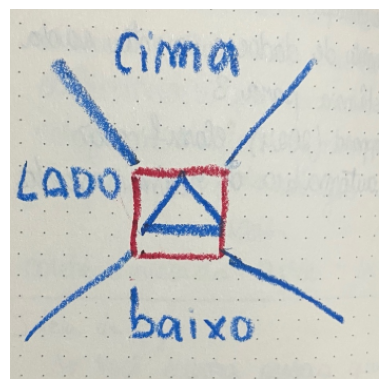

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_path = "/content/Trabalho-3-IA/referencial_espacial.png"
img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis("off")
plt.show()


>> A observação aqui é que um objeto ele pode estar em cima ou embaixo e não é algo excludente. Sendo assim, para posicionamentos horizontais usaremos X.

>> Para posicionamentos verticais usaremos Y.

### 3.1  Horizontal Posicionamento: Predicados deterministicos

In [16]:
# HORIZONTAL (LeftOf / RightOf)
class LeftOfX(nn.Module):
    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)
        return (a[:, 0] < b[:, 0]).float()

class RightOfX(nn.Module):
    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)
        return (a[:, 0] > b[:, 0]).float()


# CloseTo(x,y) (Gaussiano Treinável) # Aqui parte da ideia "O quanto é considerado perto o suficiente?"
# Daí o modelo é treinado com base nisso. Com base no quão perto ele percebe do treinamento

class CloseToGaussian(nn.Module):
    def __init__(self, gamma_init=2.0):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(float(gamma_init), device=ltn.device))

    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)

        diff = a[:, 0:2] - b[:, 0:2]      # (B,2) usa só (x,y)
        dist2 = torch.sum(diff * diff, dim=-1)
        return torch.exp(-self.gamma * dist2)


def InBetween(x, y, z):
    return multi_or(
        multi_and(LeftOf(y, x), RightOf(z, x)),
        multi_and(LeftOf(z, x), RightOf(y, x))
    )

LeftOf  = ltn.Predicate(LeftOfX().to(ltn.device))
RightOf = ltn.Predicate(RightOfX().to(ltn.device))
CloseTo = ltn.Predicate(CloseToGaussian(gamma_init=2.0).to(ltn.device))

#Daí aqui cria instancias diferentes do dataset, justamente pq vamos comparar eles nos axiomas
X = ltn.Variable("X", dataset_tensor)
Y = ltn.Variable("Y", dataset_tensor)
Z = ltn.Variable("Z", dataset_tensor)


def axioms_horizontal(include_optionals=True):
    """Axiomas da Tarefa 3.2 (Horizontal)."""
    axioms = []

    # 1. Irreflexividade: ∀x ¬LeftOf(x,x)
    axioms.append(Forall(objects, Not(LeftOf(objects, objects))))

    # 2. Assimetria: ∀x,y (LeftOf(x,y) -> ¬LeftOf(y,x))
    axioms.append(Forall([X, Y], Implies(LeftOf(X, Y), Not(LeftOf(Y, X)))))

    # 3. Inverso: ∀x,y (LeftOf(x,y) <-> RightOf(y,x))
    axioms.append(
    Forall([X, Y],
        multi_and(
            Implies(LeftOf(X, Y), RightOf(Y, X)),
            Implies(RightOf(Y, X), LeftOf(X, Y))
            )
        )
    )

    # 4. Transitividade: ∀x,y,z ((LeftOf(x,y) ∧ LeftOf(y,z)) -> LeftOf(x,z))
    axioms.append(Forall([X, Y, Z],
        Implies(
            And(LeftOf(X, Y), LeftOf(Y, Z)),
            LeftOf(X, Z)
        )
    ))

    # 5. CloseTo reflexivo: ∀x CloseTo(x,x)
    axioms.append(Forall(objects, CloseTo(objects, objects)))

    # 6. CloseTo + Triângulos -> mesmo tamanho (Restrição de Proximidade)
    same_size = multi_or(
        And(isSmall(X), isSmall(Y)),
        And(isBig(X), isBig(Y))
    )
    axioms.append(
        Forall([X, Y],
            Implies(
                multi_and(isTriangle(X), isTriangle(Y), CloseTo(X, Y)),
                same_size
            )
        )
    )

    # 7. CloseTo simétrico (opcional)
    axioms.append(
        Forall([X, Y], multi_and(
            Implies(CloseTo(X, Y), CloseTo(Y, X)),
            Implies(CloseTo(Y, X), CloseTo(X, Y))
        ))
    )

    # 8. Opcionais do enunciado
    if include_optionals:
        # Consulta Existencial (como restrição): ∃x ∀y (IsSquare(y) -> LeftOf(x,y))
        axioms.append(Exists(X, Forall(Y, Implies(isSquare(Y), LeftOf(X, Y)))))

        # Restrição Quadrado-Círculo: ∀x,y ((IsSquare(x) ∧ IsCircle(y)) -> RightOf(x,y))
        axioms.append(Forall([X, Y],
            Implies(And(isSquare(X), isCircle(Y)), RightOf(X, Y))
        ))

    return sat_agg(*axioms)


#Q1: Existe um objeto mais à esquerda de todos?
def query_last_on_the_left():
    return Exists(X, Forall(Y, LeftOf(X, Y)))

# Q2: Existe um objeto mais à direita de todos?
def query_last_on_the_right():
    return Exists(X, Forall(Y, RightOf(X, Y)))

# Q3: Existe um Cone Verde que está Entre dois outros objetos?
def query_green_cone_inbetween():
    return Exists(
        [X, Y, Z],
        multi_and(
            isCone(X),
            isGreen(X),
            InBetween(X, Y, Z)
        )
    )

# Q4: Existe pelo menos um objeto que está à Esquerda de todos os Quadrados?
def query_left_of_all_squares():
    return Exists(X, Forall(Y, Implies(isSquare(Y), LeftOf(X, Y))))

def run_queries_horizontal(tag):
    print(f"\n== CONSULTAS ESPACIAIS HORIZONTAIS ({tag}) ==")

    # Chamada das funções de query
    sat_left     = query_last_on_the_left().value.item()
    sat_right    = query_last_on_the_right().value.item()
    sat_between  = query_green_cone_inbetween().value.item()
    sat_sq_left  = query_left_of_all_squares().value.item()

    # Prints formatados
    print(f"Objeto mais à esquerda de todos?          {sat_left:.4f}")
    print(f"Objeto mais à direita de todos?           {sat_right:.4f}")
    print(f"Cone Verde entre outros dois objetos?      {sat_between:.4f}")
    print(f"Objeto à esquerda de todos os quadrados?   {sat_sq_left:.4f}")


# Otimizador doo parâmetro do CloseTo
optimizer_spatial = torch.optim.Adam(CloseTo.model.parameters(), lr=0.01)

print("=== TREINANDO CONCEITO DE PROXIMIDADE (GAMMA) ===")

for epoch in range(600):
    optimizer_spatial.zero_grad()

    # O axioma 6 (CloseTo + Triângulos = SameSize) é o que vai guiar o gamma
    sat = axioms_horizontal(include_optionals=True)

    loss = 1.0 - sat
    loss.backward()
    optimizer_spatial.step()

    if epoch % 50 == 0:
        # O gamma indica a "rigidez" do conceito de perto.
        # Gamma alto = precisa estar muito colado para ser CloseTo.
        # Gamma baixo = objetos mais distantes ainda são CloseTo.
        current_gamma = CloseTo.model.gamma.item()
        print(f"Epoch {epoch:03d} | Sat: {sat.item():.4f} | Gamma: {current_gamma:.4f}")

print("\nConceito de 'Perto' treinado com sucesso!")


# Chamada final após o treino
run_queries_horizontal("Modelo Determinístico Espacial")



=== TREINANDO CONCEITO DE PROXIMIDADE (GAMMA) ===
Epoch 000 | Sat: 0.8222 | Gamma: 2.0100
Epoch 050 | Sat: 0.8236 | Gamma: 2.5698
Epoch 100 | Sat: 0.8262 | Gamma: 3.1923
Epoch 150 | Sat: 0.8288 | Gamma: 3.7813
Epoch 200 | Sat: 0.8310 | Gamma: 4.3200
Epoch 250 | Sat: 0.8329 | Gamma: 4.8146
Epoch 300 | Sat: 0.8345 | Gamma: 5.2733
Epoch 350 | Sat: 0.8359 | Gamma: 5.7030
Epoch 400 | Sat: 0.8371 | Gamma: 6.1089
Epoch 450 | Sat: 0.8382 | Gamma: 6.4951
Epoch 500 | Sat: 0.8391 | Gamma: 6.8647
Epoch 550 | Sat: 0.8399 | Gamma: 7.2201

Conceito de 'Perto' treinado com sucesso!

== CONSULTAS ESPACIAIS HORIZONTAIS (Modelo Determinístico Espacial) ==
Objeto mais à esquerda de todos?          0.3747
Objeto mais à direita de todos?           0.3817
Cone Verde entre outros dois objetos?      0.1205
Objeto à esquerda de todos os quadrados?   0.6484


### **Notas da Aluna:** Por que o parâmetro γ (gamma) tende a valores extremos quando não há fatos explícitos?

Na ausência de fatos supervisionados que definam o que deve ser considerado "próximo", o aprendizado do parâmetro $\gamma$ torna-se dependente das restrições de consistência da Base de Conhecimento. O principal regulador desse comportamento é a Restrição de Proximidade (Axioma 6):

$$\forall x, y ((\text{IsTriangle}(x) \land \text{IsTriangle}(y) \land \text{CloseTo}(x, y)) \implies \text{SameSize}(x, y))$$

O ajuste desse parâmetro pela rede segue uma dedução lógica por negação:

> 1. O sistema identifica um par de objetos que satisfazem o predicado IsTriangle.
> 2. Ao analisar as características, nota-se que possuem tamanhos distintos (Big vs. Small).
> 3. Pelo Axioma 6, a proximidade exigiria a igualdade de tamanhos.
> 4. Dada a impossibilidade de alterar os tamanhos (que são dados de entrada), a rede minimiza o erro negando a proximidade entre os objetos.



Como resultado desse processo, o modelo tende a elevar o valor de $\gamma$ significativamente. Isso reduz o raio de alcance do kernel Gaussiano, tornando a métrica de distância extremamente rigorosa. Embora essa adaptação aumente o valor de satisfação (SatAgg) da Base de Conhecimento, ela indica que o modelo está "isolando" os objetos para evitar contradições, evidenciando a necessidade de fatos ancorados para uma calibração espacial realista.

### 3.1. Horizontal: Predicado MLP

In [17]:
import random

# para gerar supervisionamento


def gt_left_of(a, b):
    return bool(a[0].item() < b[0].item())

def gt_right_of(a, b):
    return bool(a[0].item() > b[0].item())



# Left/Right MLP com entrada 22 = concat [a||b]


class LeftRightMLP(nn.Module):
    def __init__(self, in_dim=22, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)

        inp = torch.cat([a, b], dim=1)  # (B,22)
        return self.net(inp).squeeze(-1)

LeftOf  = ltn.Predicate(LeftRightMLP(in_dim=22, hidden=16).to(ltn.device))
RightOf = ltn.Predicate(LeftRightMLP(in_dim=22, hidden=16).to(ltn.device))



# CloseTo Gaussiano com gamma treinável
class CloseToGaussian(nn.Module):
    def __init__(self, gamma_init=2.0):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(float(gamma_init), device=ltn.device))

    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)

        diff = a[:, 0:2] - b[:, 0:2]
        dist2 = torch.sum(diff * diff, dim=-1)
        return torch.exp(-self.gamma * dist2)

CloseTo = ltn.Predicate(CloseToGaussian(gamma_init=2.0).to(ltn.device))


# InBetween
def InBetween(x, y, z):
    return multi_or(
        multi_and(LeftOf(y, x), RightOf(z, x)),
        multi_and(LeftOf(z, x), RightOf(y, x))
    )


# Amostragem de pares
def sample_pair_tensors(dataset_tensor, n_pairs=200, seed=0):
    """
    Retorna 4 tensores:
      A_pos, B_pos: pares com GT LeftOf True
      A_neg, B_neg: pares com GT LeftOf False (e ax != bx)
    """
    rng = random.Random(seed)
    N = dataset_tensor.shape[0]

    A_pos, B_pos, A_neg, B_neg = [], [], [], []

    max_tries = 200 * n_pairs
    tries = 0
    while (len(A_pos) < n_pairs or len(A_neg) < n_pairs) and tries < max_tries:
        tries += 1
        i = rng.randrange(N)
        j = rng.randrange(N)
        if i == j:
            continue

        a = dataset_tensor[i]
        b = dataset_tensor[j]
        if a[0].item() == b[0].item():
            continue

        if gt_left_of(a, b):
            if len(A_pos) < n_pairs:
                A_pos.append(a); B_pos.append(b)
        else:
            if len(A_neg) < n_pairs:
                A_neg.append(a); B_neg.append(b)

    if len(A_pos) < n_pairs or len(A_neg) < n_pairs:
        print(f"[WARN] pares insuficientes: pos={len(A_pos)}/{n_pairs}, neg={len(A_neg)}/{n_pairs}")

    A_pos = torch.stack(A_pos).to(ltn.device)
    B_pos = torch.stack(B_pos).to(ltn.device)
    A_neg = torch.stack(A_neg).to(ltn.device)
    B_neg = torch.stack(B_neg).to(ltn.device)
    return A_pos, B_pos, A_neg, B_neg


# Variáveis (X,Y,Z) e variáveis supervisionadas (Pos/Neg)


X = ltn.Variable("X", dataset_tensor.to(ltn.device))
Y = ltn.Variable("Y", dataset_tensor.to(ltn.device))
Z = ltn.Variable("Z", dataset_tensor.to(ltn.device))

A_pos, B_pos, A_neg, B_neg = sample_pair_tensors(dataset_tensor, n_pairs=50, seed=0)
PosA = ltn.Variable("PosA", A_pos)
PosB = ltn.Variable("PosB", B_pos)
NegA = ltn.Variable("NegA", A_neg)
NegB = ltn.Variable("NegB", B_neg)



def axioms_horizontal_MLP(include_optionals=True):
    axioms = []

    # LeftOf positivo e negativo
    axioms.append(Forall([PosA, PosB], LeftOf(PosA, PosB)))
    axioms.append(Forall([NegA, NegB], Not(LeftOf(NegA, NegB))))

    # Ancora também RightOf (consistência)
    axioms.append(Forall([PosA, PosB], RightOf(PosB, PosA)))
    axioms.append(Forall([NegA, NegB], Not(RightOf(NegB, NegA))))

    # 1) Irreflexividade
    axioms.append(Forall(objects, Not(LeftOf(objects, objects))))

    # 2) Assimetria
    axioms.append(Forall([X, Y], Implies(LeftOf(X, Y), Not(LeftOf(Y, X)))))

    # 3) Inverso
    axioms.append(
        Forall([X, Y],
            multi_and(
                Implies(LeftOf(X, Y), RightOf(Y, X)),
                Implies(RightOf(Y, X), LeftOf(X, Y))
            )
        )
    )

    # 4) Transitividade
    axioms.append(
        Forall([X, Y, Z],
            Implies(And(LeftOf(X, Y), LeftOf(Y, Z)), LeftOf(X, Z))
        )
    )

    # 5) CloseTo reflexivo
    axioms.append(Forall(objects, CloseTo(objects, objects)))

    # 6) CloseTo + Triângulos -> mesmo tamanho.
    """3. Restri ̧c ̃ao de Proximidade (Nova Regra)”Se dois objetos s ̃ao Triˆangulos e est ̃ao Pr ́oximos
 (CloseTo), ent ̃ao eles devem ter o mesmo Tamanho.”(Esta regra for ̧ca o aprendizado a
 correlacionar espa ̧co e atributos).  """

    same_size = multi_or(And(isSmall(X), isSmall(Y)), And(isBig(X), isBig(Y)))
    axioms.append(
        Forall([X, Y],
            Implies(multi_and(isTriangle(X), isTriangle(Y), CloseTo(X, Y)), same_size)
        )
    )

    # 7) CloseTo simétrico
    axioms.append(
        Forall([X, Y],
            multi_and(
                Implies(CloseTo(X, Y), CloseTo(Y, X)),
                Implies(CloseTo(Y, X), CloseTo(X, Y))
            )
        )
    )

    # 8) opcionais
    if include_optionals:
        axioms.append(Exists(X, Forall(Y, Implies(isSquare(Y), LeftOf(X, Y)))))
        axioms.append(Forall([X, Y], Implies(And(isSquare(X), isCircle(Y)), RightOf(X, Y))))

    return sat_agg(*axioms)


# Queries
def query_last_on_the_left():
    return Exists(X, Forall(Y, LeftOf(X, Y)))

def query_last_on_the_right():
    return Exists(X, Forall(Y, RightOf(X, Y)))

def query_green_cone_inbetween():
    return Exists([X, Y, Z], multi_and(isCone(X), isGreen(X), InBetween(X, Y, Z)))

def query_left_of_all_squares():
    return Exists(X, Forall(Y, Implies(isSquare(Y), LeftOf(X, Y))))

def run_queries_horizontal(tag):
    print(f"\n== CONSULTAS ESPACIAIS HORIZONTAIS ({tag}) ==")
    print(f"Objeto mais à esquerda de todos?           {query_last_on_the_left().value.item():.4f}")
    print(f"Objeto mais à direita de todos?            {query_last_on_the_right().value.item():.4f}")
    print(f"Cone Verde entre outros dois objetos?      {query_green_cone_inbetween().value.item():.4f}")
    print(f"Objeto à esquerda de todos os quadrados?   {query_left_of_all_squares().value.item():.4f}")


# Otimizador (treina LeftOf + RightOf + gamma)
optimizer_spatial = torch.optim.Adam(
    list(LeftOf.model.parameters()) +
    list(RightOf.model.parameters()) +
    list(CloseTo.model.parameters()),
    lr=0.01
)

print("TREINANDO RELAÇÕES HORIZONTAIS + PROXIMIDADE (MLP + GAMMA)")

for epoch in range(600):
    optimizer_spatial.zero_grad(set_to_none=True)

    sat = axioms_horizontal_MLP(include_optionals=True)
    loss = 1.0 - sat

    loss.backward()
    optimizer_spatial.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Sat: {sat.item():.4f} | Gamma: {CloseTo.model.gamma.item():.4f}")

print("\nTreino concluído!")
run_queries_horizontal("Modelo Neural Espacial (22D concat)")

TREINANDO RELAÇÕES HORIZONTAIS + PROXIMIDADE (MLP + GAMMA)
Epoch 000 | Sat: 0.6406 | Gamma: 2.0100
Epoch 050 | Sat: 0.7614 | Gamma: 2.5879
Epoch 100 | Sat: 0.7852 | Gamma: 3.2511
Epoch 150 | Sat: 0.7960 | Gamma: 3.8719
Epoch 200 | Sat: 0.8041 | Gamma: 4.4370
Epoch 250 | Sat: 0.8094 | Gamma: 4.9552
Epoch 300 | Sat: 0.8135 | Gamma: 5.4346
Epoch 350 | Sat: 0.8173 | Gamma: 5.8838
Epoch 400 | Sat: 0.8203 | Gamma: 6.3091
Epoch 450 | Sat: 0.8227 | Gamma: 6.7139
Epoch 500 | Sat: 0.8247 | Gamma: 7.1012
Epoch 550 | Sat: 0.8263 | Gamma: 7.4733

Treino concluído!

== CONSULTAS ESPACIAIS HORIZONTAIS (Modelo Neural Espacial (22D concat)) ==
Objeto mais à esquerda de todos?           0.3090
Objeto mais à direita de todos?            0.3661
Cone Verde entre outros dois objetos?      0.0732
Objeto à esquerda de todos os quadrados?   0.7668


### **Notas da Aluna:** Porque colocando factos positivos e negativos de leftOf diminuiu o sat?
> Observou-se que a inclusão de fatos positivos e negativos para o predicado LeftOf reduziu a satisfazibilidade global da base de conhecimento, efeito que se intensificou à medida que o número de pares supervisionados aumentou. Cada par adicionado impõe uma nova restrição lógica, reduzindo o espaço de soluções possíveis e aumentando a probabilidade de conflitos com axiomas globais, como assimetria e transitividade. Experimentalmente, a**o utilizar 200 pares supervisionado**s, a satisfazibilidade estabilizou em aproximadamente 0.75, enquanto a redução do número de pares resultou em um aumento do valor para cerca de 0.81, aproximando-se do desempenho do modelo determinístico (ground truth). Além disso, o valor do learning rate influenciou a capacidade do modelo em acomodar essas restrições, afetando a convergência da satisfazibilidade.

## PARTE 4: RACIOCÍNIO VERTICAL

### Horizontal: determinístico

In [18]:
MAX_X = 1000.0
MAX_Y = 920.0

def get_centroid(obj_features):
    """
    Recebe:
      - tensor (11,) ou (B,11)
      - ou LTNObject (Variable/Constant), que tem .value
    Retorna:
      centroid (B,2) em coordenadas normalizadas
    """
    x = obj_features.value if hasattr(obj_features, "value") else obj_features
    if x.dim() == 1:
        x = x.unsqueeze(0)  # (1,11)

    pos_top_left = x[:, 0:2]                 # (B,2) em [0,1]
    T = x[:, 10].unsqueeze(1)                # (B,1) 0.0 small / 1.0 big

    # tamanho em pixels (exemplo didático):
    # small: 20px, big: 40px  -> deslocamento até centro ~ metade
    displacement_px = 20.0 + T * 20.0        # (B,1)

    displacement_norm_x = displacement_px / MAX_X
    displacement_norm_y = displacement_px / MAX_Y

    displacement_norm = torch.cat([displacement_norm_x, displacement_norm_y], dim=1).to(x.device)  # (B,2)
    return pos_top_left + displacement_norm



# Predicados determinísticos: Above / Below

class AboveY(nn.Module):
    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)
        # y menor = mais acima (porque y cresce pra baixo)
        return (a[:, 1] < b[:, 1]).float()

class BelowY(nn.Module):
    def forward(self, a, b):
        a = a.value if hasattr(a, "value") else a
        b = b.value if hasattr(b, "value") else b
        if a.dim() == 1: a = a.unsqueeze(0)
        if b.dim() == 1: b = b.unsqueeze(0)
        return (a[:, 1] > b[:, 1]).float()

Above = ltn.Predicate(AboveY().to(ltn.device))
Below = ltn.Predicate(BelowY().to(ltn.device))


# Estabilidade horizontal (treinável via gamma)


class StableHorizontal(nn.Module):
    """
    Mede alinhamento horizontal entre centroides.
    Quanto mais alinhados em X, mais próximo de 1.
    """
    def __init__(self, gamma_init=10.0):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(float(gamma_init), device=ltn.device))

    def forward(self, a, b):
        a_centroid = get_centroid(a)  # (B,2)
        b_centroid = get_centroid(b)  # (B,2)

        diff_x = a_centroid[:, 0] - b_centroid[:, 0]   # (B,)
        dist2_x = diff_x * diff_x

        return torch.exp(-self.gamma * dist2_x)

Stability = ltn.Predicate(StableHorizontal(gamma_init=10.0).to(ltn.device))


# canStack(x,y): x em cima de y

def canStack(x, y):
    """
    x pode ser empilhado sobre y se:
      - y não é cone e não é triângulo (base plana)
      - e x está horizontalmente estável sobre y
    """
    base_plana = And(Not(isCone(y)), Not(isTriangle(y)))
    equilibrio = Stability(x, y)
    return And(base_plana, equilibrio)


# Variáveis
X = ltn.Variable("X", dataset_tensor.to(ltn.device))
Y = ltn.Variable("Y", dataset_tensor.to(ltn.device))
Z = ltn.Variable("Z", dataset_tensor.to(ltn.device))


# Axiomas verticais (determinístico)


def axioms_vertical(train_stability_rule=True):
    axioms = []

    # Inverso: below(x,y) <-> above(y,x)
    axioms.append(
        Forall([X, Y],
            multi_and(
                Implies(Below(X, Y), Above(Y, X)),
                Implies(Above(Y, X), Below(X, Y))
            )
        )
    )

    # Transitividade: below(x,y) ∧ below(y,z) -> below(x,z)
    axioms.append(
        Forall([X, Y, Z],
            Implies(And(Below(X, Y), Below(Y, Z)), Below(X, Z))
        )
    )

    # Regra para "puxar" o gamma :

    if train_stability_rule:
        axioms.append(
            Forall([X, Y],
                Implies(
                    multi_and(Above(Y, X), Not(isCone(X)), Not(isTriangle(X))),
                    canStack(Y, X)
                )
            )
        )

    return sat_agg(*axioms)



# Query do enunciado 3.3.1 / 4.1 (composta)
def query_small_below_cylinder_left_square():
    return Exists(
        X,
        multi_and(
            isSmall(X),
            Exists(Y, And(isCylinder(Y), Below(X, Y))),
            Exists(Z, And(isSquare(Z), LeftOf(X, Z)))
        )
    )

# Query do enunciado 3.3.2 / 4.2
def query_green_cone_inbetween():
    return Exists(
        [X, Y, Z],
        multi_and(
            isCone(X),
            isGreen(X),
            InBetween(X, Y, Z)
        )
    )


# Queries verticais (exemplos)

def query_exists_stackable_pair():
    # Existe algum par (x,y) tal que x pode ser empilhado sobre y?
    return Exists([X, Y], canStack(X, Y))

def query_exists_object_below_a_cylinder():
    # Existe um objeto pequeno abaixo de um cilindro?
    return Exists([X, Y], multi_and(isSmall(X), isCylinder(Y), Below(X, Y)))



# Treino apenas do gamma da Stability


opt_vertical = torch.optim.Adam(list(Stability.model.parameters()), lr=1e-2)

print(" Treinando gamma da estabilidade horizontal (determinístico + gamma treinável) ")
for epoch in range(600):
    opt_vertical.zero_grad(set_to_none=True)

    sat = axioms_vertical(train_stability_rule=True)
    loss = 1.0 - sat
    loss.backward()
    opt_vertical.step()

    if epoch % 50 == 0:
        print(f"epoch {epoch:3d} | sat={sat.item():.4f} | Stability gamma={Stability.model.gamma.item():.4f}")

print("\n RESULTADOS (VERTICAL) ")
print("Sat vertical:", axioms_vertical(train_stability_rule=True).item())

print("--- Queries do enunciado ---")
print("Small below cylinder & left of square:", query_small_below_cylinder_left_square().value.item())
print("Green cone in between:", query_green_cone_inbetween().value.item())



print("Existe par empilhável?:", query_exists_stackable_pair().value.item())
print("Existe small abaixo de cilindro?:", query_exists_object_below_a_cylinder().value.item())


 Treinando gamma da estabilidade horizontal (determinístico + gamma treinável) 
epoch   0 | sat=0.8056 | Stability gamma=9.9900
epoch  50 | sat=0.8082 | Stability gamma=9.4854
epoch 100 | sat=0.8110 | Stability gamma=8.9638
epoch 150 | sat=0.8142 | Stability gamma=8.4213
epoch 200 | sat=0.8179 | Stability gamma=7.8552
epoch 250 | sat=0.8222 | Stability gamma=7.2622
epoch 300 | sat=0.8272 | Stability gamma=6.6382
epoch 350 | sat=0.8333 | Stability gamma=5.9777
epoch 400 | sat=0.8408 | Stability gamma=5.2738
epoch 450 | sat=0.8504 | Stability gamma=4.5167
epoch 500 | sat=0.8632 | Stability gamma=3.6932
epoch 550 | sat=0.8815 | Stability gamma=2.7834

 RESULTADOS (VERTICAL) 
Sat vertical: 0.9099128246307373
--- Queries do enunciado ---
Small below cylinder & left of square: 0.042060207575559616
Green cone in between: 0.0731717050075531
Existe par empilhável?: 0.6240674257278442
Existe small abaixo de cilindro?: 0.16391316056251526


### Horizontal: MLP model

In [19]:
import torch.nn.functional as F

# 0) GT determinístico (para supervisionar Above/Below)

def gt_above(a, b):
    # y menor = acima (y cresce pra baixo)
    return bool(a[1].item() < b[1].item())

def gt_below(a, b):
    return bool(a[1].item() > b[1].item())

Above  = ltn.Predicate(LeftRightMLP(in_dim=22, hidden=16).to(ltn.device))
Below = ltn.Predicate(LeftRightMLP(in_dim=22, hidden=16).to(ltn.device))



# 2) Centroid

MAX_X = 1000.0
MAX_Y = 920.0

def get_centroid(obj_features):
    # Garante que obj_features seja um tensor
    x = obj_features.value if hasattr(obj_features, "value") else obj_features
    if x.dim() == 1:
        x = x.unsqueeze(0)

    # Coordenadas normalizadas (devem estar entre 0 e 1)
    pos_top_left = x[:, 0:2]
    size_flag = x[:, 10].unsqueeze(1)

    displacement_px = 20.0 + (size_flag * 20.0)

    displacement_norm_x = displacement_px / (MAX_X + 1e-6)
    displacement_norm_y = displacement_px / (MAX_Y + 1e-6)

    displacement_norm = torch.cat([displacement_norm_x, displacement_norm_y], dim=1)

    centroid = pos_top_left + displacement_norm
    return centroid


# 3) Estabilidade horizontal (Gaussiano com gamma treinável)

class StableHorizontal(nn.Module):
    def __init__(self, gamma_init=10.0):
        super().__init__()
        self.raw_gamma = nn.Parameter(torch.tensor(float(gamma_init), device=ltn.device))

    def forward(self, a, b):
        # Transforma o parâmetro livre em um valor positivo
        gamma = F.softplus(self.raw_gamma)

        a_centroid = get_centroid(a)
        b_centroid = get_centroid(b)

        # Diferença horizontal
        diff_x = a_centroid[:, 0] - b_centroid[:, 0]
        dist2_x = diff_x * diff_x

        # Cálculo da exponencial com clamp para não sair de [0, 1]
        res = torch.exp(-gamma * dist2_x)
        return torch.clamp(res, min=0.0, max=1.0)


Stability = ltn.Predicate(StableHorizontal(gamma_init=10.0).to(ltn.device))


# 4) canStack(x,y): x sobre y
# enunciado: base_plana(y) e (mesmo tamanho OU centroide alinhado)

def same_size(x, y):
    return Or(
        And(isSmall(x), isSmall(y)),
        And(isBig(x), isBig(y))
    )

def canStack(x, y):
    base_plana = And(Not(isCone(y)), Not(isTriangle(y)))
    equilibrio = Or(same_size(x, y), Stability(x, y))   # <- o "OU" do enunciado
    return And(base_plana, equilibrio)




# 5) Variáveis
X = ltn.Variable("X", dataset_tensor.to(ltn.device))
Y = ltn.Variable("Y", dataset_tensor.to(ltn.device))
Z = ltn.Variable("Z", dataset_tensor.to(ltn.device))



# 6) Supervisão: amostrar pares positivos/negativos de Above


def sample_pos_neg_pairs_for_above(dataset_tensor, n_pairs=200, seed=0):
    rng = random.Random(seed)
    N = dataset_tensor.shape[0]
    A_pos, B_pos, A_neg, B_neg = [], [], [], []

    max_tries = 200 * n_pairs
    tries = 0
    while (len(A_pos) < n_pairs or len(A_neg) < n_pairs) and tries < max_tries:
        tries += 1
        i = rng.randrange(N)
        j = rng.randrange(N)
        if i == j:
            continue

        a = dataset_tensor[i]
        b = dataset_tensor[j]

        # ignora empate em Y
        if a[1].item() == b[1].item():
            continue

        if gt_above(a, b):
            if len(A_pos) < n_pairs:
                A_pos.append(a); B_pos.append(b)
        else:
            if len(A_neg) < n_pairs:
                A_neg.append(a); B_neg.append(b)

    if len(A_pos) < n_pairs or len(A_neg) < n_pairs:
        print(f"[WARN] pares insuficientes: pos={len(A_pos)}/{n_pairs}, neg={len(A_neg)}/{n_pairs}")

    return (
        torch.stack(A_pos).to(ltn.device),
        torch.stack(B_pos).to(ltn.device),
        torch.stack(A_neg).to(ltn.device),
        torch.stack(B_neg).to(ltn.device),
    )

A_pos, B_pos, A_neg, B_neg = sample_pos_neg_pairs_for_above(dataset_tensor, n_pairs=50, seed=0)
PosA = ltn.Variable("PosA", A_pos)
PosB = ltn.Variable("PosB", B_pos)
NegA = ltn.Variable("NegA", A_neg)
NegB = ltn.Variable("NegB", B_neg)





def axioms_vertical(use_supervision=True, pull_stack=True):
    axioms = []

    # (A) Supervisão direta (ancora o significado geométrico)
    if use_supervision:
        axioms.append(Forall([PosA, PosB], Above(PosA, PosB)))
        axioms.append(Forall([NegA, NegB], Not(Above(NegA, NegB))))

        # coerência: se A acima de B, então B abaixo de A
        axioms.append(Forall([PosA, PosB], Below(PosB, PosA)))

    # (B) Inverso: below(x,y) <-> above(y,x)
    axioms.append(
        Forall([X, Y],
            multi_and(
                Implies(Below(X, Y), Above(Y, X)),
                Implies(Above(Y, X), Below(X, Y))
            )
        )
    )

    # (C) Transitividade: below(x,y) ∧ below(y,z) -> below(x,z)
    axioms.append(
        Forall([X, Y, Z],
            Implies(And(Below(X, Y), Below(Y, Z)), Below(X, Z))
        )
    )

    # (D) Regra para treinar o gamma do Stability via canStack
    if pull_stack:
        axioms.append(
            Forall([X, Y],
                Implies(
                    multi_and(Above(Y, X), Not(isCone(X)), Not(isTriangle(X))),
                    canStack(Y, X)
                )
            )
        )

    return sat_agg(*axioms)




# 8) Queries

def query_exists_stackable_pair():
    return Exists([X, Y], canStack(X, Y))

def query_exists_small_below_cylinder():
    return Exists([X, Y], multi_and(isSmall(X), isCylinder(Y), Below(X, Y)))

# Query composta do enunciado =
def query_small_below_cylinder_left_square():
    return Exists(
        X,
        multi_and(
            isSmall(X),
            Exists(Y, And(isCylinder(Y), Below(X, Y))),
            Exists(Z, And(isSquare(Z), LeftOf(X, Z)))
        )
    )





params = []
params += list(Above.model.parameters())
params += list(Below.model.parameters())
params += list(Stability.model.parameters())

opt = torch.optim.Adam(params, lr=0.01)

# 3. Função de Treinamento (Corrigida para acessar o parâmetro certo no print)
params = []
params += list(Above.model.parameters())
params += list(Below.model.parameters())
params += list(Stability.model.parameters())

opt = torch.optim.Adam(params, lr=0.01)

print("=== TREINANDO VERTICAL (MLP Above/Below + gamma Stability) ===")
for epoch in range(601):
    opt.zero_grad(set_to_none=True)

    # Cálculo da satisfatibilidade dos axiomas verticais
    sat = axioms_vertical(use_supervision=True, pull_stack=True)
    loss = 1.0 - sat

    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        current_gamma = F.softplus(Stability.model.raw_gamma).item()
        print(f"epoch {epoch:03d} | sat={sat.item():.4f} | loss={loss.item():.4f} | gamma={current_gamma:.4f}")

print("\n=== RESULTADOS (VERTICAL) ===")
# Agora as queries devem funcionar
print(f"Sat vertical final: {axioms_vertical(use_supervision=True, pull_stack=True).item():.4f}")
print(f"Existe par empilhável?: {query_exists_stackable_pair().value.item():.4f}")
print(f"Existe small abaixo de cilindro?: {query_exists_small_below_cylinder().value.item():.4f}")

=== TREINANDO VERTICAL (MLP Above/Below + gamma Stability) ===
epoch 000 | sat=0.5965 | loss=0.4035 | gamma=9.9900
epoch 050 | sat=0.7215 | loss=0.2785 | gamma=9.4305
epoch 100 | sat=0.7502 | loss=0.2498 | gamma=8.8250
epoch 150 | sat=0.7678 | loss=0.2322 | gamma=8.2154
epoch 200 | sat=0.7791 | loss=0.2209 | gamma=7.5780
epoch 250 | sat=0.7899 | loss=0.2101 | gamma=6.9279
epoch 300 | sat=0.7996 | loss=0.2004 | gamma=6.2585
epoch 350 | sat=0.8087 | loss=0.1913 | gamma=5.5616
epoch 400 | sat=0.8177 | loss=0.1823 | gamma=4.8352
epoch 450 | sat=0.8240 | loss=0.1760 | gamma=4.0717
epoch 500 | sat=0.8297 | loss=0.1703 | gamma=3.2858
epoch 550 | sat=0.8351 | loss=0.1649 | gamma=2.5100
epoch 600 | sat=0.8404 | loss=0.1596 | gamma=1.8069

=== RESULTADOS (VERTICAL) ===
Sat vertical final: 0.8404
Existe par empilhável?: 0.6955
Existe small abaixo de cilindro?: 0.2234


**>> Observações**  A quantidade de exemplos positivos e negativos influenciou até mesmo a comparacao de cima e baixo. 50 pares de factos parece ser um bom numero para que o modelo entre em convergencia, talvez. Não teve diferenca entre o determinístico e o MLP

## Modelo Final (juntar todas as partes)
**>> Lembrando que** usei MLP para formas geometricas, cores, leftOF, rightOF, above, below
>> Predicados que usaram parametro matematico treinavel gamma : closeOF e canStack

>> Predicados que foram formulas logicas: beetween ((lef tOf(y, x) ∧ rightOf(z, x)) ∨ (lef tOf(z, x) ∧ rightOf(y, x)))


In [20]:
# 1. REINICIALIZAÇÃO TOTAL DOS MODELOS E PREDICADOS
isCircle   = ltn.Predicate(MLPPredicate(11))
isSquare   = ltn.Predicate(MLPPredicate(11))
isCylinder = ltn.Predicate(MLPPredicate(11))
isCone     = ltn.Predicate(MLPPredicate(11))
isTriangle = ltn.Predicate(MLPPredicate(11))
isBig      = ltn.Predicate(MLPPredicate(11))
isSmall    = ltn.Predicate(MLPPredicate(11))


isRed    = ltn.Predicate(MLPPredicate(11))
isYellow = ltn.Predicate(MLPPredicate(11))
isGreen  = ltn.Predicate(MLPPredicate(11))
isBlue   = ltn.Predicate(MLPPredicate(11))

#  Horizontal (MLP + Gamma)
LeftOf  = ltn.Predicate(LeftRightMLP(22).to(ltn.device))
RightOf = ltn.Predicate(LeftRightMLP(22).to(ltn.device))
# Usando a versão segura com softplus/raw_gamma que discutimos
CloseTo = ltn.Predicate(CloseToGaussian(gamma_init=2.0).to(ltn.device))

#  Vertical (MLP + Gamma)
Above     = ltn.Predicate(LeftRightMLP(22).to(ltn.device))
Below     = ltn.Predicate(LeftRightMLP(22).to(ltn.device))
Stability = ltn.Predicate(StableHorizontal(gamma_init=10.0).to(ltn.device))

# 2. COLETA DE PARÂMETROS PARA O OTIMIZADOR ÚNICO
def collect_params(*predicates):
    params = []
    for p in predicates:
        params += list(p.model.parameters())
    return params

full_params = collect_params(
    isCircle, isSquare, isCylinder, isCone, isTriangle, isBig, isSmall,
    isRed, isYellow, isGreen, isBlue,
    LeftOf, RightOf, CloseTo,
    Above, Below, Stability
)

optimizer_full = torch.optim.Adam(full_params, lr=0.01)

# 3. FUNÇÃO DE AGREGAÇÃO DA KB COMPLETA
def axioms_full(include_optionals=True):

    return sat_agg(
        axioms_taxonomy_MLP(),
        axioms_color_MLP(),
        axioms_horizontal_MLP(include_optionals=include_optionals),
        axioms_vertical(use_supervision=True, pull_stack=True)
    )

# 4. LOOP DE TREINAMENTO UNIFICADO
print("=== AJUSTE FINAL: TREINANDO SISTEMA NEURO-SIMBÓLICO COMPLETO ===")

for epoch in range(600):
    optimizer_full.zero_grad(set_to_none=True)

    sat = axioms_full(include_optionals=True)

    loss = 1.0 - sat
    loss.backward()
    optimizer_full.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Satisfatibilidade Global: {sat.item():.4f} | Loss: {loss.item():.4f}")

print("\n TREINAMENTO FINAL CONCLUÍDO ")

# 5. EXECUÇÃO DAS QUERIES COMPOSTAS
print(f"Query 1: Objeto pequeno abaixo de cilindro e à esquerda de quadrado: {query_small_below_cylinder_left_square().value.item():.4f}")
print(f"Query 2: Existe par empilhável?: {query_exists_stackable_pair().value.item():.4f}")
print(f"Query 3: Cone verde entre dois objetos?: {query_green_cone_inbetween().value.item():.4f}")

=== AJUSTE FINAL: TREINANDO SISTEMA NEURO-SIMBÓLICO COMPLETO ===
Epoch 000 | Satisfatibilidade Global: 0.6275 | Loss: 0.3725
Epoch 050 | Satisfatibilidade Global: 0.8114 | Loss: 0.1886
Epoch 100 | Satisfatibilidade Global: 0.8318 | Loss: 0.1682
Epoch 150 | Satisfatibilidade Global: 0.8434 | Loss: 0.1566
Epoch 200 | Satisfatibilidade Global: 0.8525 | Loss: 0.1475
Epoch 250 | Satisfatibilidade Global: 0.8598 | Loss: 0.1402
Epoch 300 | Satisfatibilidade Global: 0.8654 | Loss: 0.1346
Epoch 350 | Satisfatibilidade Global: 0.8687 | Loss: 0.1313
Epoch 400 | Satisfatibilidade Global: 0.8710 | Loss: 0.1290
Epoch 450 | Satisfatibilidade Global: 0.8730 | Loss: 0.1270
Epoch 500 | Satisfatibilidade Global: 0.8750 | Loss: 0.1250
Epoch 550 | Satisfatibilidade Global: 0.8769 | Loss: 0.1231

 TREINAMENTO FINAL CONCLUÍDO 
Query 1: Objeto pequeno abaixo de cilindro e à esquerda de quadrado: 0.0502
Query 2: Existe par empilhável?: 0.7255
Query 3: Cone verde entre dois objetos?: 0.1311


## Recaptulando as Queries com a explicação do ponto extra


Nesta seção é explicado, de forma intuitiva, como o sistema neuro-simbólico responde às
queries definidas no enunciado. Cada query retorna um grau de verdade em [0,1],
calculado a partir dos predicados neurais e das regras lógicas aprendidas.

---

### Q1 — Objeto pequeno abaixo de um cilindro e à esquerda de um quadrado

Formula:
∃x( isSmall(x) ∧ ∃y(isCylinder(y) ∧ Below(x,y)) ∧ ∃z(isSquare(z) ∧ LeftOf(x,z)) )

Raciocínio:
O modelo tenta encontrar um objeto X que satisfaça três condições ao mesmo tempo:
1. X deve ser pequeno.
2. Deve existir algum cilindro Y tal que X esteja abaixo dele.
3. Deve existir algum quadrado Z tal que X esteja à esquerda dele.

Se existir pelo menos um objeto que satisfaça todas essas restrições simultaneamente,
a query retorna um valor alto. Caso contrário, o valor diminui.

---

### Q2 — Cone verde entre dois outros objetos

Formula:
∃x,y,z( isCone(x) ∧ isGreen(x) ∧ InBetween(x,y,z) )

Raciocínio:
Primeiro o modelo procura um objeto X que seja ao mesmo tempo um cone e verde.
Em seguida, ele verifica se esse objeto está posicionado entre dois outros objetos
quaisquer (Y e Z).

O predicado InBetween não é direto: ele reutiliza as relações LeftOf e RightOf,
verificando se X está no meio de Y e Z no eixo horizontal.
Se existir algum trio que satisfaça isso, a query tem alto grau de verdade.

---

### Q3 — Existe pelo menos um par empilhável?

Formula:
∃x,y( canStack(x,y) )

Raciocínio:
O modelo avalia pares de objetos (X,Y) e verifica se eles satisfazem o predicado canStack.
Esse predicado combina várias condições, como:
- Y não ser uma forma instável (cone ou triângulo),
- X estar corretamente posicionado acima de Y,
- e haver estabilidade horizontal (alinhamento ou tamanhos compatíveis).

Se existir ao menos um par que possa ser empilhado de forma estável, a query retorna
um valor alto.

---

### Q4 — Objeto mais à esquerda de todos

Formula:
∃x( ∀y LeftOf(x,y) )

Raciocínio:
O sistema tenta encontrar um objeto X que esteja à esquerda de todos os outros objetos Y.
Aqui aparece uma quantificação universal, o que torna a condição mais rígida:
basta X falhar para um único Y para a condição enfraquecer.

Se existir um objeto que realmente seja o mais à esquerda do conjunto, a query retorna
alto valor de verdade.

---

### Q5 — Objeto mais à direita de todos

Formula:
∃x( ∀y RightOf(x,y) )

Raciocínio:
Essa query é simétrica à anterior. O modelo busca um objeto X que esteja à direita de
todos os demais objetos Y. O raciocínio segue a mesma lógica, apenas invertendo o lado.

---

### Q6 — Existe um objeto à esquerda de todos os quadrados? (Opcional)

Formula:
∃x( ∀y( isSquare(y) ⇒ LeftOf(x,y) ) )

Raciocínio:
O modelo tenta encontrar um objeto X que esteja à esquerda de todos os objetos que
forem quadrados. Para objetos que não são quadrados, a relação não é exigida.

Ou seja, X não precisa ser o mais à esquerda de todos, apenas dos quadrados.
Isso torna a consulta mais flexível do que as queries Q4 e Q5.

---

### Q7 — Restrição de proximidade entre triângulos

Formula:
∀x,y( (isTriangle(x) ∧ isTriangle(y) ∧ CloseTo(x,y)) ⇒ SameSize(x,y) )

Raciocínio:
Essa não é uma consulta existencial, mas uma regra global.
O modelo avalia todos os pares de objetos e verifica que, sempre que dois objetos
forem triângulos e estiverem próximos, eles devem possuir o mesmo tamanho.

Essa regra força o sistema a correlacionar informações espaciais (proximidade)
com atributos semânticos (tamanho), atuando como uma forma de supervisão indireta
durante o aprendizado.

---

### Observação final

As queries Q1 a Q6 avaliam a existência de configurações específicas no conjunto de objetos,
enquanto a Q7 mede o quanto o sistema respeita uma regra lógica global.
O valor de satisfatibilidade global (SAT) reflete o grau de consistência conjunta
entre todas as regras e predicados do sistema.



In [21]:
# QUERIES OBRIGATÓRIAS DO ENUNCIADO

# 1. Raciocínio Composto (Tarefa 4.1): Pequeno abaixo de Cilindro E à esquerda de Quadrado
def query_small_below_cylinder_left_square():
    return Exists(
        X,
        multi_and(
            isSmall(X),
            Exists(Y, And(isCylinder(Y), Below(X, Y))),
            Exists(Z, And(isSquare(Z), LeftOf(X, Z)))
        )
    )


# 2. Posição Absoluta (Tarefa 4.2): Cone Verde entre dois outros objetos
def query_green_cone_inbetween():
    return Exists(
        [X, Y, Z],
        multi_and(
            isCone(X),
            isGreen(X),
            InBetween(X, Y, Z)
        )
    )

# 3. Empilhamento (Tarefa 3 - canStack): Existe algum par empilhável?
def query_exists_stackable_pair():
    return Exists([X, Y], canStack(X, Y))

# 4. Objeto mais à esquerda (Tarefa 3.2): ∃x(∀y leftOf(x, y))
def query_last_on_the_left():
    return Exists(X, Forall(Y, LeftOf(X, Y)))

# 5. Objeto mais à direita (Tarefa 3.2): ∃x(∀y rightOf(x, y))
def query_last_on_the_right():
    return Exists(X, Forall(Y, RightOf(X, Y)))

# 6. Esquerda de todos os Quadrados (Tarefa 3.2 - Opcional):
def query_left_of_all_squares():
    return Exists(X, Forall(Y, Implies(isSquare(Y), LeftOf(X, Y))))

# 7. Restrição Triângulo-Proximidade (Tarefa 4.3):
# (IsTriangle(x) ∧ IsTriangle(y) ∧ CloseTo(x, y)) ⇒ SameSize(x, y)
def query_triangle_proximity_size():
    # Retorna o valor de satisfação da regra
    return Forall([X, Y], Implies(
        multi_and(isTriangle(X), isTriangle(Y), CloseTo(X, Y)),
        same_size(X, Y)
    ))

get_val = lambda x: x.value.item() if hasattr(x, "value") else x.item()

def run_all_final_queries(tag="DATASET BASE"):
    print(f"\n{'='*20} RESULTADOS QUERIES: {tag} {'='*20}")


    q1_val = get_val(query_small_below_cylinder_left_square())
    q2_val = get_val(query_green_cone_inbetween())
    q3_val = get_val(query_exists_stackable_pair())
    q4_val = get_val(query_last_on_the_left())
    q5_val = get_val(query_last_on_the_right())
    q6_val = get_val(query_left_of_all_squares())
    q7_val = get_val(query_triangle_proximity_size())

    print(f"[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: {q1_val:.4f}")
    print(f"[Q2] Cone Verde entre dois outros objetos:         {q2_val:.4f}")
    print(f"[Q3] Existe pelo menos um par empilhável (canStack): {q3_val:.4f}")
    print(f"[Q4] Objeto mais à esquerda de todos:               {q4_val:.4f}")
    print(f"[Q5] Objeto mais à direita de todos:                {q5_val:.4f}")
    print(f"[Q6] Existe objeto à esquerda de todos os Quadrados: {q6_val:.4f}")
    print(f"[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: {q7_val:.4f}")

    global_sat = get_val(axioms_full())
    print(f"\n[SATISFATIBILIDADE GLOBAL DA KB]: {global_sat:.4f}")
    print("="*60)

run_all_final_queries()


==================== RESULTADOS QUERIES: DATASET BASE ====================
[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: 0.0502
[Q2] Cone Verde entre dois outros objetos:         0.1311
[Q3] Existe pelo menos um par empilhável (canStack): 0.7255
[Q4] Objeto mais à esquerda de todos:               0.4555
[Q5] Objeto mais à direita de todos:                0.3854
[Q6] Existe objeto à esquerda de todos os Quadrados: 0.7511
[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: 0.9632

[SATISFATIBILIDADE GLOBAL DA KB]: 0.8787


## Utilizando o generator clever do professor

=== INICIANDO TESTE FINAL (5 RODADAS) ===


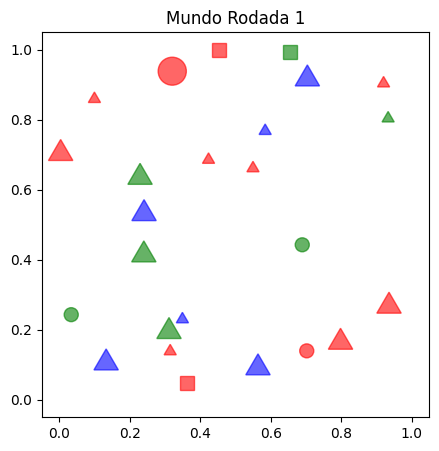


==================== RESULTADOS QUERIES: Rodada 1 ====================
[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: 0.0339
[Q2] Cone Verde entre dois outros objetos:         0.1525
[Q3] Existe pelo menos um par empilhável (canStack): 0.5991
[Q4] Objeto mais à esquerda de todos:               0.3780
[Q5] Objeto mais à direita de todos:                0.3155
[Q6] Existe objeto à esquerda de todos os Quadrados: 0.8413
[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: 0.9206

[SATISFATIBILIDADE GLOBAL DA KB]: 0.8626


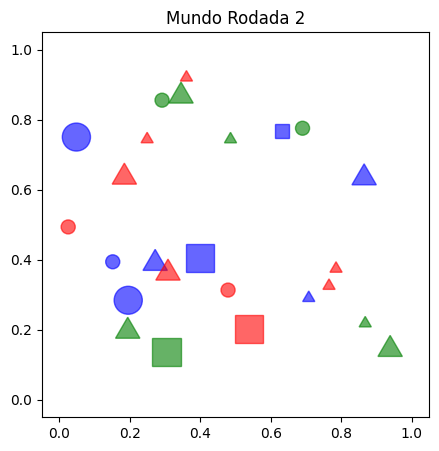


==================== RESULTADOS QUERIES: Rodada 2 ====================
[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: 0.0615
[Q2] Cone Verde entre dois outros objetos:         0.1671
[Q3] Existe pelo menos um par empilhável (canStack): 0.8242
[Q4] Objeto mais à esquerda de todos:               0.4888
[Q5] Objeto mais à direita de todos:                0.4059
[Q6] Existe objeto à esquerda de todos os Quadrados: 0.8147
[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: 0.9996

[SATISFATIBILIDADE GLOBAL DA KB]: 0.8595


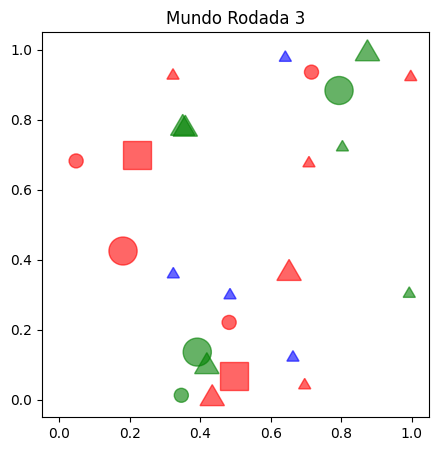


==================== RESULTADOS QUERIES: Rodada 3 ====================
[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: 0.0325
[Q2] Cone Verde entre dois outros objetos:         0.1248
[Q3] Existe pelo menos um par empilhável (canStack): 0.6807
[Q4] Objeto mais à esquerda de todos:               0.4050
[Q5] Objeto mais à direita de todos:                0.3134
[Q6] Existe objeto à esquerda de todos os Quadrados: 0.8444
[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: 0.9513

[SATISFATIBILIDADE GLOBAL DA KB]: 0.8678


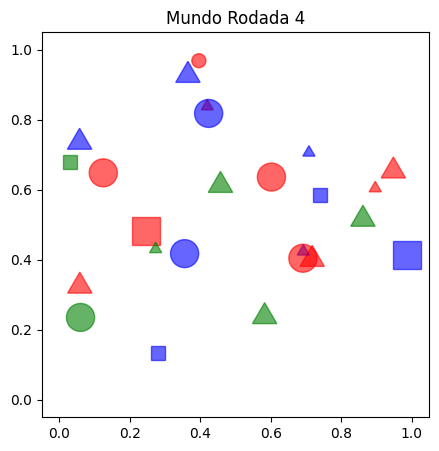


==================== RESULTADOS QUERIES: Rodada 4 ====================
[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: 0.0262
[Q2] Cone Verde entre dois outros objetos:         0.0958
[Q3] Existe pelo menos um par empilhável (canStack): 0.7075
[Q4] Objeto mais à esquerda de todos:               0.4060
[Q5] Objeto mais à direita de todos:                0.3444
[Q6] Existe objeto à esquerda de todos os Quadrados: 0.7582
[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: 0.9699

[SATISFATIBILIDADE GLOBAL DA KB]: 0.8519


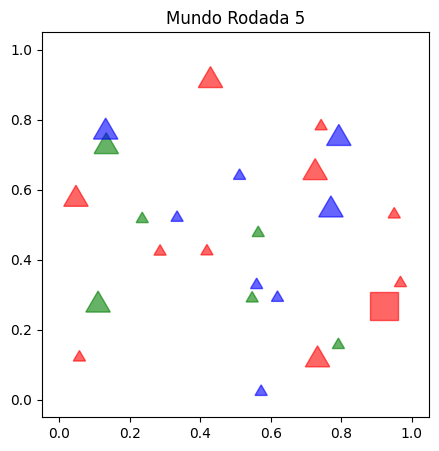


==================== RESULTADOS QUERIES: Rodada 5 ====================
[Q1] Pequeno abaixo de Cilindro E à esq. de Quadrado: 0.0444
[Q2] Cone Verde entre dois outros objetos:         0.1217
[Q3] Existe pelo menos um par empilhável (canStack): 0.5988
[Q4] Objeto mais à esquerda de todos:               0.4147
[Q5] Objeto mais à direita de todos:                0.3893
[Q6] Existe objeto à esquerda de todos os Quadrados: 0.8939
[Q7] Restrição Triângulos Próximos -> Mesmo Tamanho: 0.9411

[SATISFATIBILIDADE GLOBAL DA KB]: 0.8635

TABELA RESUMO DE GENERALIZAÇÃO
 Rodada  Acc_Formas  Acc_Tamanho  Sat_Global
      1         1.0          1.0    0.862600
      2         1.0          1.0    0.859539
      3         1.0          1.0    0.867836
      4         1.0          1.0    0.851901
      5         1.0          1.0    0.863489


In [22]:
def get_clevr_data_expanded(n_samples=100):
    """
    Gera um dataset CLEVR sintético estendido para regras complexas.
    Retorna tensor de formato (n_samples, 11).

    ESTRUTURA DO VETOR [11 features]:
    -------------------------------------------------
    [0, 1]    : Posição x, y (0.0 a 1.0)
    [2, 3, 4] : Cores One-Hot (Vermelho, Verde, Azul)
    [5, 6, 7, 8, 9] : Formas One-Hot (Círculo, Quadrado, Cilindro, Cone, Triângulo)
    [10]      : Tamanho (0.0 = Pequeno, 1.0 = Grande)
    -------------------------------------------------
    """
    data = []
    labels = []

    # Mapeamento para labels legíveis
    shapes_names = ["Circle", "Square", "Cylinder", "Cone", "Triangle"]
    colors_names = ["Red", "Green", "Blue"]
    sizes_names  = ["Small", "Large"]

    for _ in range(n_samples):
        # 1. Posição (x, y)
        x = np.random.rand()
        y = np.random.rand()

        # 2. Cor (One-hot 3 cores)
        color_idx = np.random.randint(0, 3)
        color_vec = [0.0] * 3
        color_vec[color_idx] = 1.0

        # 3. Forma (One-hot 5 formas)
        shape_idx = np.random.randint(0, 5)
        shape_vec = [0.0] * 5
        shape_vec[shape_idx] = 1.0

        # 4. Tamanho (Binário com ruído leve para realismo)
        # Se < 0.5 é Pequeno, se > 0.5 é Grande
        is_large = np.random.rand() > 0.5
        size_val = 1.0 if is_large else 0.0

        # Construção do Vetor
        # [x, y] + [r, g, b] + [s1...s5] + [size]
        vector = [x, y] + color_vec + shape_vec + [size_val]
        data.append(vector)

        desc = f"{sizes_names[int(size_val)]} {colors_names[color_idx]} {shapes_names[shape_idx]} at ({x:.2f}, {y:.2f})"
        labels.append(desc)

    tensor_data = torch.tensor(data, dtype=torch.float32)
    return tensor_data, labels

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import classification_report



def get_val(x):
    """Extrai valor numérico de objetos LTN ou tensores PyTorch."""
    if hasattr(x, "value"):
        return x.value.item()
    return x.item()



def get_performance_metrics(data_tensor):
    # Garantimos que os dados estão no device correto
    data = data_tensor.to(ltn.device)

    with torch.no_grad():
        p_circle = isCircle.model(data).cpu().numpy().flatten()
        p_square = isSquare.model(data).cpu().numpy().flatten()
        p_cylin  = isCylinder.model(data).cpu().numpy().flatten()
        p_cone   = isCone.model(data).cpu().numpy().flatten()
        p_tri    = isTriangle.model(data).cpu().numpy().flatten()

        # Monta a matriz [25, 5]
        shape_scores = np.stack([p_circle, p_square, p_cylin, p_cone, p_tri], axis=1)
        y_pred_shapes = np.argmax(shape_scores, axis=1)
        y_true_shapes = torch.argmax(data[:, 5:10], dim=1).cpu().numpy()

        # Tamanho
        p_big   = isBig.model(data).cpu().numpy().flatten()
        p_small = isSmall.model(data).cpu().numpy().flatten()
        y_pred_size = (p_big > p_small).astype(int)
        y_true_size = data[:, 10].cpu().numpy().astype(int)

    # Cálculo de acurácia simples
    acc_f = (y_pred_shapes == y_true_shapes).mean()
    acc_t = (y_pred_size == y_true_size).mean()

    return acc_f, acc_t

# 3. FUNÇÃO DE PLOT
def plot_clevr_world(data_tensor, rodada_idx):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f"Mundo Rodada {rodada_idx}")
    for obj in data_tensor:
        x, y = obj[0].item(), obj[1].item()
        color = 'red' if obj[2]==1 else 'green' if obj[3]==1 else 'blue'
        size = 0.04 if obj[10]==1 else 0.02
        if obj[5]==1: shape = patches.Circle((x,y), size, color=color, alpha=0.6)
        elif obj[6]==1: shape = patches.Rectangle((x-size,y-size), size*2, size*2, color=color, alpha=0.6)
        else: shape = patches.RegularPolygon((x,y), 3, radius=size, color=color, alpha=0.6)
        ax.add_patch(shape)
    plt.show()

# 4. LOOP FINAL DE EXECUÇÃO
final_history = []

print("=== INICIANDO TESTE FINAL (5 RODADAS) ===")

for i in range(1, 6):
    # Gera dados novos
    test_data, _ = get_clevr_data_expanded(25)
    test_data = test_data.to(ltn.device)

    X = ltn.Variable("X", test_data)
    Y = ltn.Variable("Y", test_data)
    Z = ltn.Variable("Z", test_data)
    objects = ltn.Variable("objects", test_data)

    # Visualização e Queries
    plot_clevr_world(test_data, i)
    run_all_final_queries(tag=f"Rodada {i}")

    # Métricas
    acc_f, acc_t = get_performance_metrics(test_data)

    final_history.append({
        "Rodada": i,
        "Acc_Formas": acc_f,
        "Acc_Tamanho": acc_t,
        "Sat_Global": get_val(axioms_full())
    })

# 5. TABELA RESUMO FINAL
df_resumo = pd.DataFrame(final_history)
print("\n" + "="*45)
print("TABELA RESUMO DE GENERALIZAÇÃO")
print("="*45)
print(df_resumo.to_string(index=False))
